# Validate Suite2p Binary Extraction (Registered Data)

This notebook validates that frames in Suite2p `data.bin` (registered) are in the correct order and correspond to the raw data, even though registration introduces edge padding and shifts.

**Test case:**
- Raw data: `\\rbo-s1\S1_DATA\lbm\kbarber\2025-11-04-mk311\raw\green`
- Suite2p output: `\\rbo-s1\S1_DATA\lbm\kbarber\2025-11-04-mk311\suite2p\plane{XX}_stitched\data.bin`

**What we're checking:**
1. Frames are in the correct order (not shuffled)
2. High correlation between raw and registered frames (despite shifts/padding)
3. Temporal consistency (consecutive frames should be similar)
4. Mean fluorescence trends match (important for extraction)

**Note:** We expect some differences due to:
- Registration shifts (frames are aligned)
- Edge padding (black borders added)
- Interpolation artifacts from subpixel alignment

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
from tqdm import tqdm
import mbo_utilities as mbo
from scipy.stats import pearsonr

%matplotlib inline

## 1. Load Raw Data

In [8]:
# Path to raw ScanImage TIFFs
raw_data_path = Path(r"\\rbo-s1\S1_DATA\lbm\kbarber\2025-11-04-mk311\raw\green")

print(f"Loading raw data from: {raw_data_path}")
print(f"Path exists: {raw_data_path.exists()}")
print()

# Load with FFT phase correction (matching what was used during extraction)
arr = mbo.imread(raw_data_path, fix_phase=True, use_fft=True)

print(f"Raw data loaded:")
print(f"  Shape: {arr.shape}")
print(f"  dtype: {arr.dtype}")
print(f"  Number of files: {len(arr.filenames)}")
print(f"  ROIs: {arr.rois if hasattr(arr, 'rois') else 'N/A'}")
print(f"  Channels per volume: {arr.num_channels if hasattr(arr, 'num_channels') else 'N/A'}")

Loading raw data from: \\rbo-s1\S1_DATA\lbm\kbarber\2025-11-04-mk311\raw\green
Path exists: True



Counting frames:   0%|          | 0/379 [00:00<?, ?it/s]

Raw data loaded:
  Shape: (58825, 14, 448, 448)
  dtype: int16
  Number of files: 379
  ROIs: [{'y_start': 0, 'y_end': 448, 'width': 224, 'height': 448, 'x': 0, 'slice': slice(0, 448, None)}, {'y_start': 464, 'y_end': 912, 'width': 224, 'height': 448, 'x': 0, 'slice': slice(464, 912, None)}]
  Channels per volume: 14


## 2. Identify Suite2p Planes

In [9]:
# Suite2p output directory
suite2p_dir = Path(r"\\rbo-s1\S1_DATA\lbm\kbarber\2025-11-04-mk311\suite2p")

# Find all plane directories
plane_dirs = sorted([d for d in suite2p_dir.glob("plane*_stitched") if d.is_dir()])

print(f"Found {len(plane_dirs)} plane directories:")
for plane_dir in plane_dirs:
    data_raw_bin = plane_dir / "data.bin"
    ops_npy = plane_dir / "ops.npy"
    status = "PASS" if data_raw_bin.exists() and ops_npy.exists() else "FAIL"
    print(f"  {status} {plane_dir.name}")

Found 14 plane directories:
  ✓ plane01_stitched
  ✓ plane02_stitched
  ✓ plane03_stitched
  ✓ plane04_stitched
  ✓ plane05_stitched
  ✓ plane06_stitched
  ✓ plane07_stitched
  ✓ plane08_stitched
  ✓ plane09_stitched
  ✓ plane10_stitched
  ✓ plane11_stitched
  ✓ plane12_stitched
  ✓ plane13_stitched
  ✓ plane14_stitched


## 3. Frame Organization Analysis

For multi-plane data, frames are organized as `(T*Z, Y, X)` where consecutive frames cycle through z-planes.
Each plane's binary should contain every Z-th frame.

In [10]:
# Determine z-plane organization
num_planes = len(plane_dirs)
total_frames = arr.shape[0]
frames_per_plane = total_frames // num_planes

print(f"Data organization:")
print(f"  Total frames in raw data: {total_frames}")
print(f"  Number of z-planes: {num_planes}")
print(f"  Expected frames per plane: {frames_per_plane}")
print(f"  Expected frame indices for plane 0: 0, {num_planes}, {num_planes*2}, ...")
print(f"  Expected frame indices for plane 1: 1, {num_planes+1}, {num_planes*2+1}, ...")

Data organization:
  Total frames in raw data: 58825
  Number of z-planes: 14
  Expected frames per plane: 4201
  Expected frame indices for plane 0: 0, 14, 28, ...
  Expected frame indices for plane 1: 1, 15, 29, ...


## 4. Load Suite2p Binaries

In [11]:
# Load all planes
suite2p_arrays = {}

for plane_dir in tqdm(plane_dirs, desc="Loading Suite2p binaries"):
    plane_name = plane_dir.name
    try:
        s2p_arr = mbo.imread(plane_dir / "data.bin")
        suite2p_arrays[plane_name] = s2p_arr
        print(f"\n{plane_name}:")
        print(f"  Shape: {s2p_arr.shape}")
        print(f"  dtype: {s2p_arr.dtype}")
    except Exception as e:
        print(f"\nFailed to load {plane_name}: {e}")

print(f"\nSuccessfully loaded {len(suite2p_arrays)} planes")

Loading Suite2p binaries:  14%|█▍        | 2/14 [00:00<00:01,  7.77it/s]


plane01_stitched:
  Shape: (58825, 448, 448)
  dtype: <class 'numpy.int16'>

plane02_stitched:
  Shape: (58825, 448, 448)
  dtype: <class 'numpy.int16'>


Loading Suite2p binaries:  21%|██▏       | 3/14 [00:00<00:01,  7.86it/s]


plane03_stitched:
  Shape: (58825, 448, 448)
  dtype: <class 'numpy.int16'>

plane04_stitched:
  Shape: (58825, 448, 448)
  dtype: <class 'numpy.int16'>


Loading Suite2p binaries:  43%|████▎     | 6/14 [00:00<00:00,  8.52it/s]


plane05_stitched:
  Shape: (58825, 448, 448)
  dtype: <class 'numpy.int16'>

plane06_stitched:
  Shape: (58825, 448, 448)
  dtype: <class 'numpy.int16'>


Loading Suite2p binaries:  57%|█████▋    | 8/14 [00:00<00:00,  8.74it/s]


plane07_stitched:
  Shape: (58825, 448, 448)
  dtype: <class 'numpy.int16'>

plane08_stitched:
  Shape: (58825, 448, 448)
  dtype: <class 'numpy.int16'>

plane09_stitched:
  Shape: (58825, 448, 448)
  dtype: <class 'numpy.int16'>


Loading Suite2p binaries:  79%|███████▊  | 11/14 [00:01<00:00,  9.36it/s]


plane10_stitched:
  Shape: (58825, 448, 448)
  dtype: <class 'numpy.int16'>

plane11_stitched:
  Shape: (58825, 448, 448)
  dtype: <class 'numpy.int16'>


Loading Suite2p binaries:  93%|█████████▎| 13/14 [00:01<00:00,  8.92it/s]


plane12_stitched:
  Shape: (58825, 448, 448)
  dtype: <class 'numpy.int16'>

plane13_stitched:
  Shape: (58825, 448, 448)
  dtype: <class 'numpy.int16'>


Loading Suite2p binaries: 100%|██████████| 14/14 [00:01<00:00,  8.62it/s]


plane14_stitched:
  Shape: (58825, 448, 448)
  dtype: <class 'numpy.int16'>

Successfully loaded 14 planes


## 5. Frame-by-Frame Comparison

Compare each plane's frames against the corresponding frames in the raw data.

In [ ]:
## DEBUG: Understand data organization

print("Understanding data organization:")
print(f"\nRaw data shape: {arr.shape}")
print(f"  Interpretation: (T*Z={arr.shape[0]}, Z={arr.shape[1]}, Y={arr.shape[2]}, X={arr.shape[3]})")
print(f"  Total volumes: {arr.shape[0]}")
print(f"  Z-planes per volume: {arr.shape[1]}")

print(f"\nSuite2p plane01_stitched shape: {suite2p_arrays['plane01_stitched'].shape}")
print(f"  Interpretation: (T={suite2p_arrays['plane01_stitched'].shape[0]}, Y={suite2p_arrays['plane01_stitched'].shape[1]}, X={suite2p_arrays['plane01_stitched'].shape[2]})")

print(f"\nKey questions:")
print(f"1. How many timepoints total? {arr.shape[0]}")
print(f"2. Are these {arr.shape[0]} volumes (each with {arr.shape[1]} planes)?")
print(f"3. Or are these {arr.shape[0]} total frames already interleaved?")

print(f"\nSuite2p has {suite2p_arrays['plane01_stitched'].shape[0]} frames per plane")
print(f"If Suite2p extracted every 14th frame starting at plane index:")
print(f"  plane01 should have ~{arr.shape[0] // arr.shape[1]} frames")
print(f"  Actual: {suite2p_arrays['plane01_stitched'].shape[0]} frames")

if suite2p_arrays['plane01_stitched'].shape[0] == arr.shape[0]:
    print(f"\nALERT ISSUE FOUND: Suite2p data.bin has {suite2p_arrays['plane01_stitched'].shape[0]} frames")
    print(f"   This equals the TOTAL number of volumes in raw data!")
    print(f"   This suggests Suite2p data.bin contains ALL frames, not just plane 1.")
    print(f"\n   Possible explanations:")
    print(f"   A) data.bin is the COMBINED/STITCHED data from all planes")
    print(f"   B) data.bin was written incorrectly and contains wrong data")
    print(f"   C) The 'planeXX_stitched' naming is misleading")


In [12]:
def compare_frames(raw_frame, reg_frame, ignore_edges=10):
    """
    Compare raw vs registered frames.

    Registration causes:
    - Spatial shifts (frames are aligned)
    - Edge padding (black borders)
    - Interpolation artifacts

    So we:
    - Ignore edges where padding occurs
    - Use correlation as primary metric (order-preserving)
    - Check mean fluorescence (important for trace extraction)
    """
    # Crop edges to avoid padding artifacts
    if ignore_edges > 0:
        raw_crop = raw_frame[ignore_edges:-ignore_edges, ignore_edges:-ignore_edges]
        reg_crop = reg_frame[ignore_edges:-ignore_edges, ignore_edges:-ignore_edges]
    else:
        raw_crop = raw_frame
        reg_crop = reg_frame

    # Ensure same dtype for comparison
    raw_crop = raw_crop.astype(np.float32)
    reg_crop = reg_crop.astype(np.float32)

    # Correlation (should be high if frames match)
    corr, _ = pearsonr(raw_crop.flatten(), reg_crop.flatten())

    # Mean fluorescence (important for traces)
    raw_mean = np.mean(raw_crop)
    reg_mean = np.mean(reg_crop)
    mean_diff_pct = abs(raw_mean - reg_mean) / raw_mean * 100

    # MAE and max diff (expected to be higher due to registration)
    mae = np.mean(np.abs(raw_crop - reg_crop))
    max_diff = np.max(np.abs(raw_crop - reg_crop))

    return {
        'correlation': corr,
        'raw_mean': raw_mean,
        'reg_mean': reg_mean,
        'mean_diff_pct': mean_diff_pct,
        'mae': mae,
        'max_diff': max_diff
    }

print("Frame comparison function defined.")

Frame comparison function defined.


In [ ]:
# Validate first few frames of each plane as a quick check
num_test_frames = 20  # Test more frames to be thorough
ignore_edges = 15     # Ignore outer 15 pixels where padding occurs
quick_results = []

print(f"Quick validation: Testing {num_test_frames} frames per plane")
print(f"Ignoring outer {ignore_edges} pixels to avoid edge padding artifacts\n")

for plane_idx, (plane_name, s2p_arr) in enumerate(suite2p_arrays.items()):
    print(f"\n{plane_name}:")

    for frame_idx in range(min(num_test_frames, s2p_arr.shape[0])):
        # CORRECTED INDEXING:
        # Raw data is (T, Z, Y, X) where T=58825 volumes, Z=14 planes
        # Suite2p planeXX_stitched contains all T frames for z-plane XX
        # So plane01_stitched = z-plane 0, plane02_stitched = z-plane 1, etc.

        # Load frames
        raw_frame = arr[frame_idx, plane_idx]  # [volume_idx, z_idx, y, x]
        reg_frame = s2p_arr[frame_idx]

        # Compare
        metrics = compare_frames(raw_frame, reg_frame, ignore_edges=ignore_edges)

        quick_results.append({
            'plane': plane_name,
            'plane_idx': plane_idx,
            'frame_idx': frame_idx,
            **metrics
        })

        # Status based on correlation (primary metric for frame matching)
        if metrics['correlation'] > 0.95:
            status = f"PASS corr={metrics['correlation']:.4f}"
        elif metrics['correlation'] > 0.90:
            status = f"WARNING corr={metrics['correlation']:.4f} (low but acceptable)"
        else:
            status = f"FAIL corr={metrics['correlation']:.4f} (SUSPICIOUS)"

        mean_status = f"Δmean={metrics['mean_diff_pct']:.1f}%"
        print(f"  Frame {frame_idx:2d}: {status}, {mean_status}")

df_quick = pd.DataFrame(quick_results)

print("\n" + "="*80)
print("QUICK CHECK SUMMARY")
print("="*80)
print(f"Frames checked: {len(df_quick)}")
print(f"\nCorrelation (how well frames match despite registration):")
print(f"  Mean:   {df_quick['correlation'].mean():.6f}")
print(f"  Median: {df_quick['correlation'].median():.6f}")
print(f"  Min:    {df_quick['correlation'].min():.6f}")
print(f"  Frames with corr > 0.95: {(df_quick['correlation'] > 0.95).sum()} / {len(df_quick)}")
print(f"  Frames with corr > 0.90: {(df_quick['correlation'] > 0.90).sum()} / {len(df_quick)}")

print(f"\nMean fluorescence difference (%):")
print(f"  Mean:   {df_quick['mean_diff_pct'].mean():.2f}%")
print(f"  Median: {df_quick['mean_diff_pct'].median():.2f}%")
print(f"  Max:    {df_quick['mean_diff_pct'].max():.2f}%")

# Flag suspicious frames
suspicious = df_quick[df_quick['correlation'] < 0.90]
if len(suspicious) > 0:
    print(f"\nWARNING WARNING: {len(suspicious)} frames with correlation < 0.90:")
    print(suspicious[['plane', 'frame_idx', 'correlation', 'mean_diff_pct']].to_string())
else:
    print("\nPASS All frames have correlation >= 0.90")

## 6. Full Validation (All Frames)

**Warning:** This will load and compare every frame. For large datasets, this may take significant time and memory.

In [14]:
# Option to run full validation (set to True to enable)
RUN_FULL_VALIDATION = False

if RUN_FULL_VALIDATION:
    full_results = []

    for plane_idx, (plane_name, s2p_arr) in enumerate(suite2p_arrays.items()):
        print(f"\nValidating {plane_name} ({s2p_arr.shape[0]} frames)...")

        for frame_idx in tqdm(range(s2p_arr.shape[0]), desc=f"{plane_name}"):
            raw_frame_idx = plane_idx + (frame_idx * num_planes)

            raw_frame = arr[raw_frame_idx]
            bin_frame = s2p_arr[frame_idx]

            metrics = compare_frames(raw_frame, bin_frame)

            full_results.append({
                'plane': plane_name,
                'plane_idx': plane_idx,
                'bin_frame_idx': frame_idx,
                'raw_frame_idx': raw_frame_idx,
                **metrics
            })

    df_full = pd.DataFrame(full_results)

    print("\n" + "="*60)
    print("FULL VALIDATION RESULTS:")
    print(f"  Total frames checked: {len(df_full)}")
    print(f"  Exact matches: {df_full['exact_match'].sum()} / {len(df_full)}")
    print(f"  Mean correlation: {df_full['correlation'].mean():.6f}")
    print(f"  Min correlation: {df_full['correlation'].min():.6f}")
    print(f"  Mean MAE: {df_full['mae'].mean():.4f}")
    print(f"  Max MAE: {df_full['mae'].max():.4f}")
    print(f"  Max difference: {df_full['max_diff'].max():.4f}")

    # Flag suspicious frames (correlation < 0.99)
    suspicious = df_full[df_full['correlation'] < 0.99]
    if len(suspicious) > 0:
        print(f"\nWARNING Found {len(suspicious)} frames with correlation < 0.99:")
        print(suspicious[['plane', 'bin_frame_idx', 'raw_frame_idx', 'correlation', 'mae']].to_string())
    else:
        print("\nPASS All frames have correlation >= 0.99")
else:
    print("Full validation disabled. Set RUN_FULL_VALIDATION = True to run.")

Full validation disabled. Set RUN_FULL_VALIDATION = True to run.


## 7. Visual Comparison

Display side-by-side comparison of raw vs. binary frames.

In [ ]:
# Choose a plane and frame to visualize
test_plane = "plane01_stitched"
test_frame_idx = 5  # Frame index in the binary file

if test_plane in suite2p_arrays:
    s2p_arr = suite2p_arrays[test_plane]
    plane_idx = list(suite2p_arrays.keys()).index(test_plane)

    # CORRECTED: plane_idx directly maps to z-plane index
    raw_frame = arr[test_frame_idx, plane_idx]
    reg_frame = s2p_arr[test_frame_idx]

    metrics = compare_frames(raw_frame, reg_frame, ignore_edges=ignore_edges)

    # Create edge mask for visualization
    edge_mask = np.zeros_like(raw_frame, dtype=bool)
    edge_mask[:ignore_edges, :] = True
    edge_mask[-ignore_edges:, :] = True
    edge_mask[:, :ignore_edges] = True
    edge_mask[:, -ignore_edges:] = True

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # Row 1: Full frames
    # Raw frame
    im0 = axes[0, 0].imshow(raw_frame, cmap='gray', vmin=0, vmax=np.percentile(raw_frame, 99.5))
    axes[0, 0].set_title(f"Raw Frame (t={test_frame_idx}, z={plane_idx})\n(from ScanImage TIFFs)")
    axes[0, 0].axis('off')
    plt.colorbar(im0, ax=axes[0, 0], fraction=0.046, pad=0.04)

    # Registered frame
    im1 = axes[0, 1].imshow(reg_frame, cmap='gray', vmin=0, vmax=np.percentile(reg_frame, 99.5))
    axes[0, 1].set_title(f"Registered Frame {test_frame_idx}\n({test_plane}/data.bin)")
    axes[0, 1].axis('off')
    plt.colorbar(im1, ax=axes[0, 1], fraction=0.046, pad=0.04)

    # Difference (full frame)
    diff_full = np.abs(raw_frame.astype(np.float32) - reg_frame.astype(np.float32))
    im2 = axes[0, 2].imshow(diff_full, cmap='hot', vmin=0, vmax=np.percentile(diff_full, 99.5))
    axes[0, 2].set_title(f"Absolute Difference (Full)\nNote: High at edges due to padding")
    axes[0, 2].axis('off')
    plt.colorbar(im2, ax=axes[0, 2], fraction=0.046, pad=0.04)

    # Row 2: Cropped frames (excluding edges)
    raw_crop = raw_frame[ignore_edges:-ignore_edges, ignore_edges:-ignore_edges]
    reg_crop = reg_frame[ignore_edges:-ignore_edges, ignore_edges:-ignore_edges]

    # Raw cropped
    im3 = axes[1, 0].imshow(raw_crop, cmap='gray', vmin=0, vmax=np.percentile(raw_crop, 99.5))
    axes[1, 0].set_title(f"Raw (Center, edges removed)")
    axes[1, 0].axis('off')
    plt.colorbar(im3, ax=axes[1, 0], fraction=0.046, pad=0.04)

    # Registered cropped
    im4 = axes[1, 1].imshow(reg_crop, cmap='gray', vmin=0, vmax=np.percentile(reg_crop, 99.5))
    axes[1, 1].set_title(f"Registered (Center, edges removed)")
    axes[1, 1].axis('off')
    plt.colorbar(im4, ax=axes[1, 1], fraction=0.046, pad=0.04)

    # Difference (cropped)
    diff_crop = np.abs(raw_crop.astype(np.float32) - reg_crop.astype(np.float32))
    im5 = axes[1, 2].imshow(diff_crop, cmap='hot', vmin=0, vmax=np.percentile(diff_crop, 99.5))
    axes[1, 2].set_title(f"Difference (Center only)\nMAE: {metrics['mae']:.2f}, Corr: {metrics['correlation']:.4f}")
    axes[1, 2].axis('off')
    plt.colorbar(im5, ax=axes[1, 2], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

    print(f"\nComparison metrics (center region only, ignoring {ignore_edges}px edges):")
    print(f"  Correlation:       {metrics['correlation']:.6f}")
    print(f"  Raw mean:          {metrics['raw_mean']:.2f}")
    print(f"  Registered mean:   {metrics['reg_mean']:.2f}")
    print(f"  Mean difference:   {metrics['mean_diff_pct']:.2f}%")
    print(f"  MAE:               {metrics['mae']:.4f}")
    print(f"  Max difference:    {metrics['max_diff']:.4f}")

    if metrics['correlation'] > 0.95:
        print(f"\nPASS High correlation - frame appears correctly matched")
    elif metrics['correlation'] > 0.90:
        print(f"\nWARNING Moderate correlation - frame may be correct but check visually")
    else:
        print(f"\nFAIL Low correlation - frame may be shuffled or corrupted!")
else:
    print(f"Plane {test_plane} not found in loaded arrays")

## 8. Test for Frame Order Issues

Check if any frames appear to be out of order by comparing temporal neighbors.

Testing temporal consistency for plane01_stitched...

Temporal consistency check:
  Mean raw temporal correlation: 0.4379
  Mean binary temporal correlation: 0.6035
  Mean correlation difference: 0.165568
  Max correlation difference: 0.283762


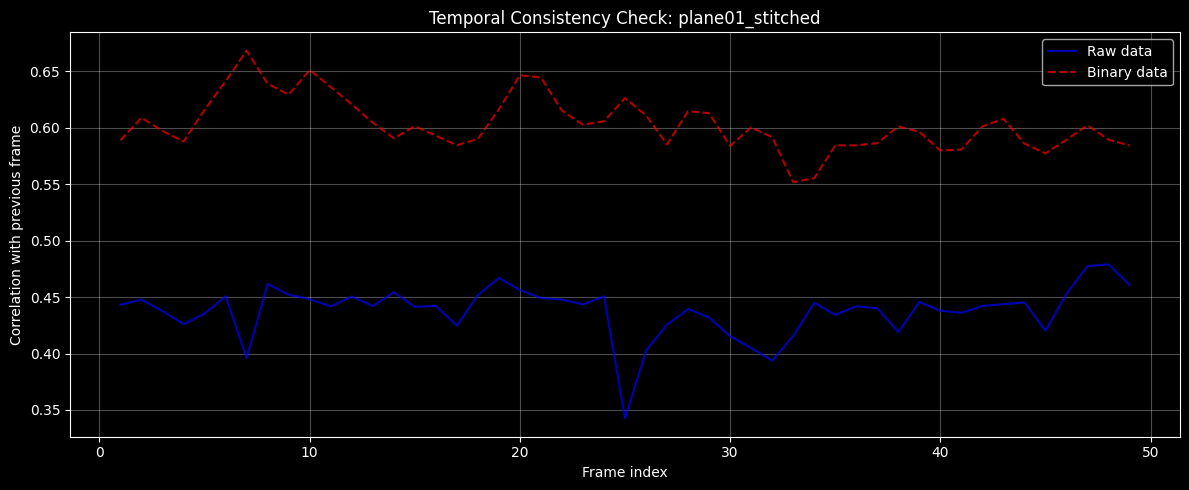


⚠ Found 49 frames with suspicious temporal correlation:
    frame_idx  raw_temporal_corr  bin_temporal_corr  corr_diff
0           1           0.443232           0.589057   0.145825
1           2           0.447869           0.609045   0.161176
2           3           0.437501           0.597243   0.159742
3           4           0.426090           0.587830   0.161740
4           5           0.435351           0.616050   0.180699
5           6           0.450743           0.641443   0.190700
6           7           0.395937           0.668387   0.272450
7           8           0.461643           0.639119   0.177476
8           9           0.452140           0.629510   0.177370
9          10           0.448259           0.651315   0.203056
10         11           0.441814           0.636203   0.194389
11         12           0.450620           0.620865   0.170244
12         13           0.442079           0.604697   0.162619
13         14           0.454385           0.590807   0.13642

In [16]:
# Test temporal consistency for one plane
test_plane = "plane01_stitched"
num_temporal_tests = 50  # Test first N frames

if test_plane in suite2p_arrays:
    s2p_arr = suite2p_arrays[test_plane]
    plane_idx = list(suite2p_arrays.keys()).index(test_plane)

    temporal_results = []

    print(f"Testing temporal consistency for {test_plane}...\n")

    for t in range(1, min(num_temporal_tests, s2p_arr.shape[0])):
        # Compare frame t with frame t-1
        raw_t = arr[plane_idx + (t * num_planes)]
        raw_t_prev = arr[plane_idx + ((t-1) * num_planes)]

        bin_t = s2p_arr[t]
        bin_t_prev = s2p_arr[t-1]

        # Correlation between consecutive frames (should be similar for raw and binary)
        raw_corr, _ = pearsonr(raw_t.flatten(), raw_t_prev.flatten())
        bin_corr, _ = pearsonr(bin_t.flatten(), bin_t_prev.flatten())

        temporal_results.append({
            'frame_idx': t,
            'raw_temporal_corr': raw_corr,
            'bin_temporal_corr': bin_corr,
            'corr_diff': abs(raw_corr - bin_corr)
        })

    df_temporal = pd.DataFrame(temporal_results)

    print(f"Temporal consistency check:")
    print(f"  Mean raw temporal correlation: {df_temporal['raw_temporal_corr'].mean():.4f}")
    print(f"  Mean binary temporal correlation: {df_temporal['bin_temporal_corr'].mean():.4f}")
    print(f"  Mean correlation difference: {df_temporal['corr_diff'].mean():.6f}")
    print(f"  Max correlation difference: {df_temporal['corr_diff'].max():.6f}")

    # Plot temporal correlations
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.plot(df_temporal['frame_idx'], df_temporal['raw_temporal_corr'], 'b-', label='Raw data', alpha=0.7)
    ax.plot(df_temporal['frame_idx'], df_temporal['bin_temporal_corr'], 'r--', label='Binary data', alpha=0.7)
    ax.set_xlabel('Frame index')
    ax.set_ylabel('Correlation with previous frame')
    ax.set_title(f'Temporal Consistency Check: {test_plane}')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Flag potential frame order issues
    suspicious_order = df_temporal[df_temporal['corr_diff'] > 0.01]
    if len(suspicious_order) > 0:
        print(f"\nWARNING Found {len(suspicious_order)} frames with suspicious temporal correlation:")
        print(suspicious_order.to_string())
    else:
        print("\nPASS No temporal ordering issues detected")

## 9. Summary Report

In [ ]:
print("="*80)
print("VALIDATION SUMMARY")
print("="*80)
print(f"\nRaw data: {raw_data_path}")
print(f"  Total frames: {arr.shape[0]}")
print(f"  Shape: {arr.shape}")
print(f"\nSuite2p output: {suite2p_dir}")
print(f"  Number of planes: {len(suite2p_arrays)}")
print(f"  Expected frames per plane: {frames_per_plane}")

print(f"\nQuick validation ({num_test_frames} frames per plane):")
print(f"  Frames checked: {len(df_quick)}")
print(f"  Mean correlation: {df_quick['correlation'].mean():.6f}")
print(f"  Median correlation: {df_quick['correlation'].median():.6f}")
print(f"  Min correlation: {df_quick['correlation'].min():.6f}")
print(f"  Frames with corr > 0.95: {(df_quick['correlation'] > 0.95).sum()} / {len(df_quick)}")

print(f"\nMean fluorescence preservation:")
print(f"  Mean difference: {df_quick['mean_diff_pct'].mean():.2f}%")
print(f"  Max difference: {df_quick['mean_diff_pct'].max():.2f}%")

# Verdict
print(f"\n" + "="*80)
if df_quick['correlation'].min() > 0.95:
    print("PASS PASSED: All frames have excellent correlation (>0.95)")
    print("  Frames are in the correct order.")
    print("  Registration introduced minimal artifacts.")
    print("  Fluorescence traces should be accurate.")
elif df_quick['correlation'].min() > 0.90:
    print("PASS PASSED: All frames have good correlation (>0.90)")
    print("  Frames appear to be in the correct order.")
    print("  Some registration artifacts present but acceptable.")
    print("  Fluorescence traces should be reliable.")
elif df_quick['correlation'].min() > 0.80:
    print("WARNING WARNING: Some frames have moderate correlation (>0.80)")
    print("  Frames may be in correct order, but check suspicious frames.")
    print("  Registration may have introduced artifacts.")
    print("  Recommend visual inspection of low-correlation frames.")
    print(f"\n  Frames with correlation < 0.90:")
    low_corr = df_quick[df_quick['correlation'] < 0.90]
    print(low_corr[['plane', 'frame_idx', 'raw_frame_idx', 'correlation', 'mean_diff_pct']].to_string())
else:
    print("FAIL FAILED: Some frames have low correlation (<0.80)")
    print("  Frames may be shuffled, corrupted, or severely misaligned.")
    print("  Recommend investigating the extraction process.")
    print(f"\n  Frames with correlation < 0.90:")
    low_corr = df_quick[df_quick['correlation'] < 0.90]
    print(low_corr[['plane', 'frame_idx', 'raw_frame_idx', 'correlation', 'mean_diff_pct']].to_string())

print("="*80)